# Music Recommendation from Audio Features (Spotify Tracks)
### Advanced Statistical Learning Project using PyTorch

**Goal:** Build a content-based music recommender from Spotify track-level features by:
1) Training a neural network to predict `track_genre` (multi-class classification).
2) Reusing the **penultimate layer** as an **embedding** and recommending similar tracks using **cosine similarity**.

---

## Experiments (two)
### Q1 — Batch size impact (speed vs. performance)
We evaluate how different batch sizes affect:
- training time (`sec/epoch`)
- test performance (Accuracy, Macro-F1)
- recommendation proxy (Genre-Hit@10)

### Q2 — Depth × Learning Rate interaction
We test whether deeper networks need different learning rates to train well, and how depth affects:
- performance
- training time per epoch

---

## Dataset
Local path:
`/Users/Phillip/Downloads/spotify_train.csv`

The notebook is written to be reproducible:
- fixed random seeds  
- stratified train/val/test split  
- no data leakage in preprocessing (scaler fit on train only)


### 1. Imports and global settings

We import:
- **pandas/numpy** for data
- **sklearn** for train/val/test split + scaling
- **PyTorch** for model + training loop
- **matplotlib** for plots

We also set random seeds to make experimental comparisons fair.



In [1]:
# Block 1 — Imports + seed + device
import os
import time
import random
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility (important!)
# ----------------------------

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)






Using device: cpu


### 2. Load the dataset and validate columns

This cell:
- loads the local CSV file
- selects the feature columns used in the model
- checks that required columns exist (fail fast if the CSV schema differs)

**Modeling note:**  
We intentionally keep the feature set small and interpretable:
- numeric audio features (continuous)
- a few discrete metadata fields (mode/key/etc.) treated as categorical and embedded




In [2]:
# Block 2 — Load CSV + drop common Kaggle index artifact
DATA_PATH = "/Users/Phillip/Downloads/spotify_train.csv"
df = pd.read_csv(DATA_PATH)

# Common Kaggle artifact: an unnamed index column
for c in df.columns:
    if c.lower().startswith("unnamed"):
        df = df.drop(columns=[c])

TARGET_COL = "track_genre"

# Numeric audio features
NUM_COLS = [
    "popularity", "duration_ms", "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

# Discrete/categorical-ish (treated as categorical)
CAT_COLS = ["explicit", "key", "mode", "time_signature"]

# Keep only needed columns (drop everything else so modeling is clear)
keep_cols = NUM_COLS + CAT_COLS + [TARGET_COL]
missing = [c for c in keep_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

df = df[keep_cols].dropna(subset=[TARGET_COL]).reset_index(drop=True)

print("Rows:", len(df))
print("Example rows:")
display(df.head(3))



Rows: 114000
Example rows:


,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit,key,mode,time_signature,track_genre
0,73,230666,0.676,0.461,-6.746,0.1430,0.0322,0.000001,0.358,0.715,87.917,False,1,0,4,acoustic
1,55,149610,0.420,0.166,-17.235,0.0763,0.9240,0.000006,0.101,0.267,77.489,False,1,1,4,acoustic
2,57,210826,0.438,0.359,-9.734,0.0557,0.2100,0.000000,0.117,0.120,76.332,False,0,1,4,acoustic


### 3. Target encoding and data split (no leakage)

We:
- clean the data (type coercion and missing values)
- encode `track_genre` into integer labels
- create a **stratified** 70/15/15 train–validation–test split

**Why stratified?**  
Genre labels are typically imbalanced. Stratification keeps class proportions similar across splits, so train/val/test are comparable.


In [3]:
# Block 3 — Define features/target + clean types + drop missing
TARGET_COL = "track_genre"

NUM_COLS = [
    "popularity", "duration_ms", "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo"
]
CAT_COLS = ["explicit", "key", "mode", "time_signature"]

needed = [TARGET_COL] + NUM_COLS + CAT_COLS
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}\nFound columns: {df.columns.tolist()}")

df2 = df.dropna(subset=needed).copy()
df2 = df2.reset_index(drop=True)  # stable indexing (important for recommender/q2 sampling)

# explicit -> int 0/1 (robust to bool/str/0/1)
if df2["explicit"].dtype == bool:
    df2["explicit"] = df2["explicit"].astype(int)
else:
    df2["explicit"] = (
        df2["explicit"].astype(str).str.lower()
        .map({"true":1, "false":0})
        .fillna(df2["explicit"])
    )
    df2["explicit"] = pd.to_numeric(df2["explicit"], errors="coerce").fillna(0).astype(int)

# numeric coercion
for c in NUM_COLS:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
df2 = df2.dropna(subset=NUM_COLS).copy()

# categorical ints
for c in ["key", "mode", "time_signature"]:
    df2[c] = pd.to_numeric(df2[c], errors="coerce").fillna(0).astype(int)

print("After cleaning:", df2.shape)
print("# genres:", df2[TARGET_COL].nunique())
df2[TARGET_COL].value_counts().head(10)



After cleaning: (114000, 16)
# genres: 114


track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
pop-film             1000
piano                1000
party                1000
pagode               1000
opera                1000
Name: count, dtype: int64

### Block 4: Train-only preprocessing (scaler + categorical mappings)

This block prepares the model inputs in a leakage-safe way:

- **Standardization:** numeric features are standardized with `StandardScaler`
  - fit on **train** only
  - apply to val/test using the same parameters
- **Categorical encoding:** discrete columns are mapped to integer IDs
  - mapping is built from **train** only
  - unseen values in val/test map to 0 ("unknown")

This ensures your test metrics are not inflated by accidentally using information from the test split during preprocessing.

In [4]:
# Block 4 — Stratified split + scaler (train-only) + categorical vocab (train-only)
idx_all = np.arange(len(df2))

X = df2[NUM_COLS + CAT_COLS].copy()
y = df2[TARGET_COL].copy()

# Encode genres to integer labels 0..C-1
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)

# 70/15/15 stratified split
idx_train, idx_temp, y_train, y_temp = train_test_split(
    idx_all, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

X_train = X.iloc[idx_train]
X_val   = X.iloc[idx_val]
X_test  = X.iloc[idx_test]

# Scale numeric features (fit only on train)
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[NUM_COLS])
X_val_num   = scaler.transform(X_val[NUM_COLS])
X_test_num  = scaler.transform(X_test[NUM_COLS])

# Categorical mapping based on train only
cat_maps: Dict[str, Dict[int, int]] = {}
for c in CAT_COLS:
    uniq = sorted(X_train[c].unique().tolist())
    cat_maps[c] = {int(v): i for i, v in enumerate(uniq)}

def map_cats(df_part: pd.DataFrame) -> np.ndarray:
    cols = []
    for c in CAT_COLS:
        m = cat_maps[c]
        cols.append(df_part[c].map(lambda v: m.get(int(v), 0)).astype(int).values)  # unseen -> 0
    return np.stack(cols, axis=1)

X_train_cat = map_cats(X_train)
X_val_cat   = map_cats(X_val)
X_test_cat  = map_cats(X_test)

cat_cardinalities = [len(cat_maps[c]) for c in CAT_COLS]

print("Split sizes:", len(idx_train), len(idx_val), len(idx_test))
print("Num classes:", len(le_y.classes_))
print("Cat cardinalities:", dict(zip(CAT_COLS, cat_cardinalities)))



Split sizes: 79800 17100 17100
Num classes: 114
Cat cardinalities: {'explicit': 2, 'key': 12, 'mode': 2, 'time_signature': 5}


### Block 5: Dataset wrapper (PyTorch)

We wrap preprocessed arrays into a `torch.utils.data.Dataset` for use with `DataLoader`.

Each sample returns:
- `x_num` (float32): standardized numeric features
- `x_cat` (int64): integer IDs for categorical features
- `y` (int64): target class index

This clean separation makes it easy to:
- feed numeric features directly into linear layers
- feed categorical IDs into embedding layers


In [5]:
# Block 5 — PyTorch Dataset wrapper
class SpotifyTabularDataset(Dataset):
    def __init__(self, X_num: np.ndarray, X_cat: np.ndarray, y: np.ndarray):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]





### Block 6: Model architecture (Tabular MLP)

We use a **feedforward neural network** for tabular data:

1) Categorical features → embeddings  
2) Concatenate embeddings + numeric features  
3) MLP with ReLU nonlinearity + dropout  
4) Linear classification head → logits over genres

**Why this model?**
- The dataset is a fixed-length feature vector per track.
- An MLP is a strong baseline for nonlinear interactions between audio features.
- The model is fast to train and easy to ablate (depth, width, optimizer, etc.).

**Important for recommendation:**  
The model is implemented so we can return both:
- logits for classification
- the penultimate hidden representation as an embedding for nearest-neighbor recommendation

In [6]:
# Block 6 — Tabular MLP model (FFN) + optional embedding output for recommendation
class TabularMLP(nn.Module):
    """
    - Embeds categorical inputs
    - Concats with numeric inputs
    - MLP backbone (depth = len(hidden_dims))
    - Classification head outputs logits for genre prediction
    - return_embedding=True returns penultimate layer h for recommendations
    """
    def __init__(self, num_features, cat_cardinalities, hidden_dims, dropout, num_classes):
        super().__init__()
        cat_embed_dims = [min(16, max(2, int(math.sqrt(c)))) for c in cat_cardinalities]
        self.embeds = nn.ModuleList([
            nn.Embedding(card, dim) for card, dim in zip(cat_cardinalities, cat_embed_dims)
        ])
        emb_out = sum(cat_embed_dims)

        layers = []
        in_dim = num_features + emb_out
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            in_dim = h

        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, num_classes)

    def forward(self, x_num, x_cat, return_embedding: bool = False):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeds)]
        x = torch.cat([x_num] + embs, dim=1)
        h = self.backbone(x)
        logits = self.head(h)
        if return_embedding:
            return logits, h
        return logits


### Block 7: Training configuration

We package training hyperparameters into a small config object to make experiments clean and reproducible.

This includes:
- network depth / hidden sizes
- batch size
- learning rate
- optimizer choice
- max epochs + early stopping patience

Keeping these in a config object reduces copy/paste errors between experiments.

In [7]:
# Block 7 — TrainConfig + optimizer factory
@dataclass
class TrainConfig:
    hidden_dims: List[int]
    dropout: float = 0.2
    lr: float = 1e-3
    batch_size: int = 512
    epochs: int = 15
    weight_decay: float = 1e-4
    optimizer_name: str = "adamw"  # "adam", "adamw", "sgd"
    patience: int = 3

def make_optimizer(model, cfg: TrainConfig):
    name = cfg.optimizer_name.lower()
    if name == "adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)
    raise ValueError(f"Unknown optimizer: {cfg.optimizer_name}")




### Block 8: Evaluation metrics

We compute:
- **Accuracy**: overall fraction correct
- **Macro-F1**: averages F1 per class (treats each genre equally)

Macro-F1 is especially useful with class imbalance, where accuracy can look good even if minority genres are predicted poorly.


In [8]:
# Block 8 — Evaluation: classification metrics
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, preds = [], []
    total_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    for x_num, x_cat, y in loader:
        x_num, x_cat, y = x_num.to(DEVICE), x_cat.to(DEVICE), y.to(DEVICE)
        logits = model(x_num, x_cat)
        loss = loss_fn(logits, y)

        total_loss += float(loss.item()) * len(y)
        pred = torch.argmax(logits, dim=1)

        ys.append(y.cpu().numpy())
        preds.append(pred.cpu().numpy())

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    return {
        "loss": total_loss / len(ys),
        "acc": accuracy_score(ys, preds),
        "f1_macro": f1_score(ys, preds, average="macro")
    }




### Block 9: Training loop with early stopping

This block defines the training procedure used in every experiment.

Key elements:
- Cross-entropy loss for multi-class classification
- Early stopping using validation Macro-F1 (prevents overtraining)
- Tracking of:
  - `epochs_ran` (needed for fair time-per-epoch comparisons)
  - training time (seconds) for speed analysis

The function returns both the trained model and a compact training history that we can log and plot.


In [9]:
# Block 9 — Training loop + early stopping + epochs_ran (for time/epoch comparisons)
def train_one_run(cfg: TrainConfig, verbose=True):
    seed_everything(42)

    train_loader = DataLoader(
        SpotifyTabularDataset(X_train_num, X_train_cat, y_train),
        batch_size=cfg.batch_size, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(
        SpotifyTabularDataset(X_val_num, X_val_cat, y_val),
        batch_size=cfg.batch_size, shuffle=False, num_workers=0
    )
    test_loader = DataLoader(
        SpotifyTabularDataset(X_test_num, X_test_cat, y_test),
        batch_size=cfg.batch_size, shuffle=False, num_workers=0
    )

    model = TabularMLP(
        num_features=len(NUM_COLS),
        cat_cardinalities=cat_cardinalities,
        hidden_dims=cfg.hidden_dims,
        dropout=cfg.dropout,
        num_classes=len(le_y.classes_)
    ).to(DEVICE)

    optimizer = make_optimizer(model, cfg)
    loss_fn = nn.CrossEntropyLoss()

    best_val_f1 = -1.0
    best_state = None
    bad_epochs = 0
    hist = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    t0 = time.time()
    epochs_ran = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        running, n = 0.0, 0

        for x_num, x_cat, y in train_loader:
            x_num, x_cat, y = x_num.to(DEVICE), x_cat.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x_num, x_cat)
            loss = loss_fn(logits, y)

            # Divergence guard (useful for deep + too-high LR)
            if not torch.isfinite(loss):
                if verbose:
                    print("Non-finite loss encountered (training diverged).")
                epochs_ran = epoch
                train_time = time.time() - t0
                test_metrics = evaluate(model, test_loader)
                return model, hist, test_metrics, train_time, epochs_ran

            loss.backward()
            optimizer.step()

            running += float(loss.item()) * len(y)
            n += len(y)

        train_loss = running / n
        val_metrics = evaluate(model, val_loader)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_metrics["loss"])
        hist["val_acc"].append(val_metrics["acc"])
        hist["val_f1"].append(val_metrics["f1_macro"])

        epochs_ran = epoch

        if verbose:
            print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_f1={val_metrics['f1_macro']:.4f}")

        if val_metrics["f1_macro"] > best_val_f1:
            best_val_f1 = val_metrics["f1_macro"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= cfg.patience:
                if verbose:
                    print("Early stopping.")
                break

    train_time = time.time() - t0

    if best_state is not None:
        model.load_state_dict(best_state)

    test_metrics = evaluate(model, test_loader)
    return model, hist, test_metrics, train_time, epochs_ran




### Block 10: Recommendation (embedding retrieval) + recommender metric

We turn the classifier into a content-based recommender:

1) Compute embeddings for tracks (penultimate layer)
2) L2-normalize embeddings → cosine similarity becomes a dot product
3) For each query track:
   - find top-K nearest neighbors in the reference set
   - compute **Genre-Hit@10**: fraction of neighbors with the same genre

**Why Genre-Hit@10?**  
We do not have user interaction logs, so we cannot evaluate personalized recommendation.  
Genre-Hit@10 is a simple proxy: it checks whether the embedding space clusters tracks in a genre-consistent way.

In [10]:

@torch.no_grad()
def compute_embeddings(model, X_num: np.ndarray, X_cat: np.ndarray, batch_size: int = 2048) -> np.ndarray:
    ds = SpotifyTabularDataset(X_num, X_cat, np.zeros(len(X_num), dtype=int))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()

    embs = []
    for x_num, x_cat, _ in loader:
        x_num, x_cat = x_num.to(DEVICE), x_cat.to(DEVICE)
        _, h = model(x_num, x_cat, return_embedding=True)
        embs.append(h.cpu().numpy())

    E = np.vstack(embs)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)  # cosine-ready
    return E

def recommender_metrics(
    model,
    k: int = 10,
    n_query: int = 1500,
    n_ref: int = 20000,
    seed: int = 42
):
    rng = np.random.default_rng(seed)

    # Build embeddings for ALL tracks using the same preprocessing pipeline
    X_all = df2[NUM_COLS + CAT_COLS].copy()
    X_all_num = scaler.transform(X_all[NUM_COLS])
    X_all_cat = map_cats(X_all)

    # Block 10 — Recommender: embeddings + metrics + demo
    E_all = compute_embeddings(model, X_all_num, X_all_cat)

    # Query from TEST, recommend from TRAIN
    q_pool = idx_test
    r_pool = idx_train

    q_samp = rng.choice(q_pool, size=min(n_query, len(q_pool)), replace=False)
    r_samp = rng.choice(r_pool, size=min(n_ref, len(r_pool)), replace=False)

    Q = E_all[q_samp]
    R = E_all[r_samp]
    sims = Q @ R.T

    # top-k indices for each query row
    topk = np.argpartition(-sims, kth=k-1, axis=1)[:, :k]

    q_genres = df2.iloc[q_samp][TARGET_COL].values
    r_genres = df2.iloc[r_samp][TARGET_COL].values

    hit_fracs = []
    for i in range(len(q_samp)):
        rec_genres = r_genres[topk[i]]
        hit_fracs.append(np.mean(rec_genres == q_genres[i]))

    genre_hit_at_k = float(np.mean(hit_fracs))

    max_sims = np.max(np.take_along_axis(sims, topk, axis=1), axis=1)
    avg_best_sim = float(np.mean(max_sims))

    return {"genre_hit@k": genre_hit_at_k, "avg_best_sim": avg_best_sim}

def recommend_demo(model, query_row_index: int, k: int = 10):
    X_all = df2[NUM_COLS + CAT_COLS].copy()
    X_all_num = scaler.transform(X_all[NUM_COLS])
    X_all_cat = map_cats(X_all)
    E_all = compute_embeddings(model, X_all_num, X_all_cat)

    q = E_all[query_row_index]
    R = E_all[idx_train]
    sims = R @ q

    top = np.argsort(-sims)[:k]
    rec_indices = np.array(idx_train)[top]

    cols = [c for c in ["track_name", "artists", "album_name", TARGET_COL] if c in df2.columns]
    print("QUERY:")
    print(df2.iloc[query_row_index][cols], "\n")
    print(f"TOP-{k} RECOMMENDATIONS (from TRAIN pool):")
    display(df2.iloc[rec_indices][cols].assign(similarity=sims[top]))






### Block 11: Baseline sanity check

Before running hyperparameter sweeps, we run one baseline configuration to confirm:
- the model trains without errors
- metrics are computed correctly
- the recommendation pipeline (embeddings + retrieval) produces sensible output

This also gives a reference point for later experiments.

In [11]:
# Block 11 — Baseline run (sanity check) + demo recommendation
base_cfg = TrainConfig(
    hidden_dims=[256, 256, 128],
    optimizer_name="adamw",
    lr=1e-3,
    batch_size=512,
    epochs=15,
    patience=3
)

model, hist, test, train_time, epochs_ran = train_one_run(base_cfg, verbose=True)
rec = recommender_metrics(model, k=10, n_query=1200, n_ref=20000, seed=42)

print("\nBaseline TEST:", test)
print("Baseline Recommender:", rec)
print("Train time (sec):", train_time, "| epochs ran:", epochs_ran)

# Demo: show recommendations for one test track
query_idx = int(idx_test[0])
recommend_demo(model, query_row_index=query_idx, k=40)



Epoch 01 | train_loss=3.9240 | val_f1=0.1389
Epoch 02 | train_loss=3.3745 | val_f1=0.1889
Epoch 03 | train_loss=3.2094 | val_f1=0.2036
Epoch 04 | train_loss=3.1043 | val_f1=0.2213
Epoch 05 | train_loss=3.0367 | val_f1=0.2315
Epoch 06 | train_loss=2.9783 | val_f1=0.2432
Epoch 07 | train_loss=2.9356 | val_f1=0.2494
Epoch 08 | train_loss=2.9010 | val_f1=0.2553
Epoch 09 | train_loss=2.8699 | val_f1=0.2561
Epoch 10 | train_loss=2.8478 | val_f1=0.2659
Epoch 11 | train_loss=2.8250 | val_f1=0.2651
Epoch 12 | train_loss=2.8042 | val_f1=0.2728
Epoch 13 | train_loss=2.7904 | val_f1=0.2769
Epoch 14 | train_loss=2.7727 | val_f1=0.2803
Epoch 15 | train_loss=2.7547 | val_f1=0.2846

Baseline TEST: {'loss': 2.6374912228500635, 'acc': 0.3003508771929825, 'f1_macro': 0.2784321490693795}
Baseline Recommender: {'genre_hit@k': 0.2021666666666667, 'avg_best_sim': 0.9638097286224365}
Train time (sec): 18.53957509994507 | epochs ran: 15
QUERY:
track_genre    classical
Name: 16840, dtype: object 

TOP-40 RECOMM

,track_genre,similarity
16694,classical,0.987055
16832,classical,0.986658
16998,classical,0.986408
16866,classical,0.985287
16827,classical,0.985155
16982,classical,0.984197
16876,classical,0.982772
16793,classical,0.982644
16725,classical,0.981544
16780,classical,0.980053


### Block 12: Q1: Batch size impact on training time (+ accuracy/recs)

**Question (Q1):** What is the impact of batch size on training time and model quality?

We vary:
- `batch_size ∈ {64, 256, 1024, 4096}`

We measure:
- **Compute:** total training time and seconds/epoch
- **Classification:** test Accuracy and Macro-F1
- **Recommendation proxy:** Genre-Hit@10

**Practical note:**  
Very large batches can cause out-of-memory errors on some GPUs/CPUs. The code catches these errors so the experiment can still finish.


In [12]:
# Block 12 — Q1 experiment: batch size

batch_sizes = [64, 256, 1024, 4096]

Q1_rows = []
for bs in batch_sizes:
    cfg = TrainConfig(
        hidden_dims=[256, 256, 128],
        optimizer_name="adamw",
        lr=1e-3,
        batch_size=bs,
        epochs=20,
        patience=4,
        dropout=0.2,
        weight_decay=1e-4
    )

    print(f"\n=== Q1: batch_size={bs} ===")
    try:
        model, hist, test, train_time, epochs_ran = train_one_run(cfg, verbose=False)
        rec = recommender_metrics(model, k=10, n_query=1200, n_ref=20000, seed=42)

        Q1_rows.append({
            "batch_size": bs,
            "epochs_ran": epochs_ran,
            "train_time_sec": train_time,
            "sec_per_epoch": train_time / max(1, epochs_ran),
            "test_acc": test["acc"],
            "test_f1_macro": test["f1_macro"],
            "genre_hit@10": rec["genre_hit@k"],
        })
        print(Q1_rows[-1])

    except RuntimeError as e:
        print(f"Skipped batch_size={bs} due to RuntimeError: {str(e)[:140]}...")
        Q1_rows.append({
            "batch_size": bs,
            "epochs_ran": 0,
            "train_time_sec": np.nan,
            "sec_per_epoch": np.nan,
            "test_acc": np.nan,
            "test_f1_macro": np.nan,
            "genre_hit@10": np.nan,
            "note": "OOM/RuntimeError"
        })

Q1_df = pd.DataFrame(Q1_rows).sort_values("batch_size")
Q1_df





=== Q1: batch_size=64 ===
{'batch_size': 64, 'epochs_ran': 20, 'train_time_sec': 56.83120107650757, 'sec_per_epoch': 2.8415600538253782, 'test_acc': 0.3188888888888889, 'test_f1_macro': 0.2984544403497931, 'genre_hit@10': 0.21875}

=== Q1: batch_size=256 ===
{'batch_size': 256, 'epochs_ran': 20, 'train_time_sec': 30.333014011383057, 'sec_per_epoch': 1.5166507005691527, 'test_acc': 0.312280701754386, 'test_f1_macro': 0.2907002042386739, 'genre_hit@10': 0.21616666666666665}

=== Q1: batch_size=1024 ===
{'batch_size': 1024, 'epochs_ran': 20, 'train_time_sec': 22.622599124908447, 'sec_per_epoch': 1.1311299562454225, 'test_acc': 0.2986549707602339, 'test_f1_macro': 0.27403303593974804, 'genre_hit@10': 0.2044166666666667}

=== Q1: batch_size=4096 ===
{'batch_size': 4096, 'epochs_ran': 20, 'train_time_sec': 23.824278116226196, 'sec_per_epoch': 1.1912139058113098, 'test_acc': 0.2691228070175439, 'test_f1_macro': 0.23903114846595666, 'genre_hit@10': 0.18941666666666668}


,batch_size,epochs_ran,train_time_sec,sec_per_epoch,test_acc,test_f1_macro,genre_hit@10
0,64,20,56.831201,2.841560,0.318889,0.298454,0.218750
1,256,20,30.333014,1.516651,0.312281,0.290700,0.216167
2,1024,20,22.622599,1.131130,0.298655,0.274033,0.204417
3,4096,20,23.824278,1.191214,0.269123,0.239031,0.189417


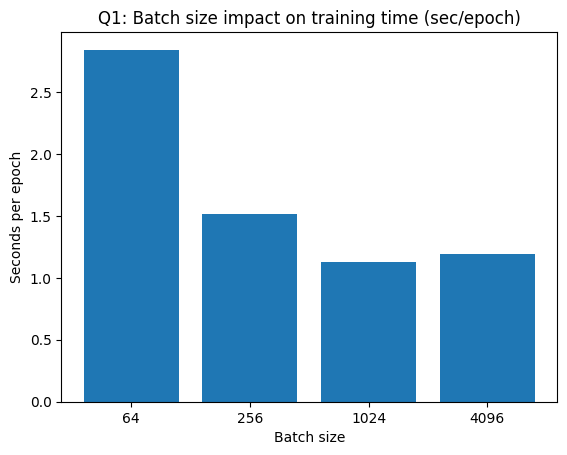

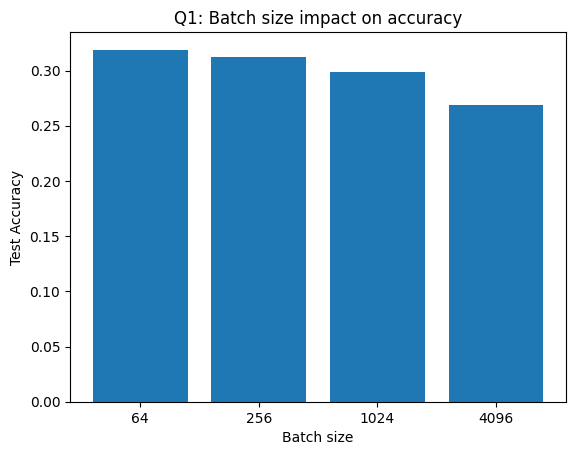

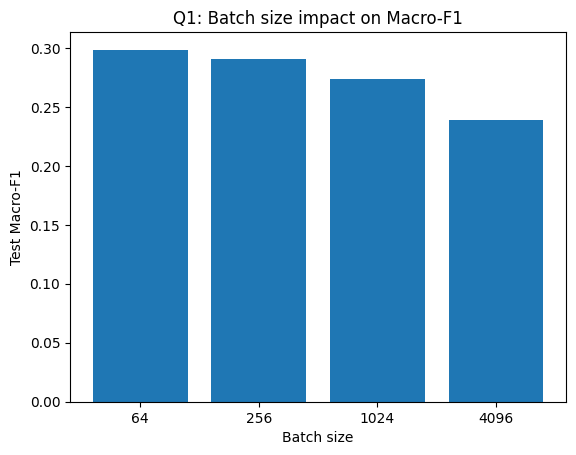

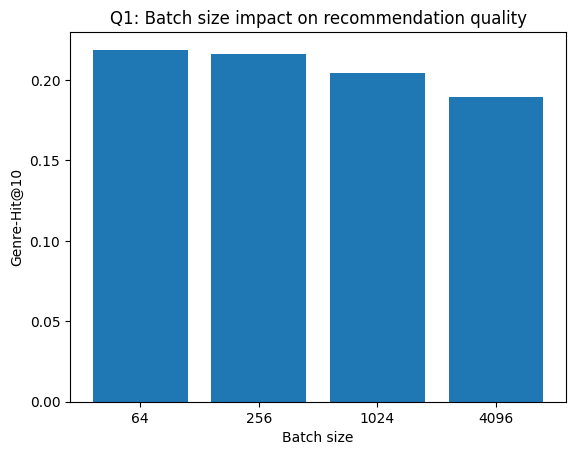

In [13]:
# Q1 plots (time + accuracy + macro-F1 + recommender quality)
plt.figure()
plt.bar(Q1_df["batch_size"].astype(str), Q1_df["sec_per_epoch"])
plt.xlabel("Batch size"); plt.ylabel("Seconds per epoch")
plt.title("Q1: Batch size impact on training time (sec/epoch)")
plt.show()

plt.figure()
plt.bar(Q1_df["batch_size"].astype(str), Q1_df["test_acc"])
plt.xlabel("Batch size"); plt.ylabel("Test Accuracy")
plt.title("Q1: Batch size impact on accuracy")
plt.show()

plt.figure()
plt.bar(Q1_df["batch_size"].astype(str), Q1_df["test_f1_macro"])
plt.xlabel("Batch size"); plt.ylabel("Test Macro-F1")
plt.title("Q1: Batch size impact on Macro-F1")
plt.show()

plt.figure()
plt.bar(Q1_df["batch_size"].astype(str), Q1_df["genre_hit@10"])
plt.xlabel("Batch size"); plt.ylabel("Genre-Hit@10")
plt.title("Q1: Batch size impact on recommendation quality")
plt.show()


## Block 13 — Q2: Depth × Learning Rate experiment

**Goal:** Test whether **deeper networks** need different **learning rates** to achieve good performance, and how depth affects **training time**.

- We loop over a grid of:
  - `depth ∈ {2, 6, 10}`
  - `lr ∈ {1e-4, 3e-4, 1e-3, 3e-3}`
- We keep everything else fixed (same split, preprocessing, batch size, optimizer type, epochs/early stopping).
- For each (depth, lr) setting we train a fresh model and record:
  - `epochs_ran`, `sec_per_epoch`
  - `test_acc`, `test_f1_macro`
  - `genre_hit@10` (recommendation proxy using embedding similarity)

**Output:** a results DataFrame used in the next block to create heatmaps (Figures 4–5).


In [23]:
# Block 13 — Q2 experiment: depth × learning rate

def make_hidden_dims(depth: int, width: int = 128) -> List[int]:
    return [width] * depth

depths = [2, 6, 10]
lrs = [1e-4, 3e-4, 1e-3, 3e-3]

Q2_rows = []
for d in depths:
    for lr in lrs:
        cfg = TrainConfig(
            hidden_dims=make_hidden_dims(d, width=128),
            optimizer_name="adamw",
            lr=lr,
            batch_size=512,
            epochs=25,
            patience=5,
            dropout=0.1,
            weight_decay=1e-4
        )

        print(f"\n=== Q2: depth={d}, lr={lr} ===")
        try:
            model, hist, test, train_time, epochs_ran = train_one_run(cfg, verbose=False)
            rec = recommender_metrics(model, k=10, n_query=1000, n_ref=20000, seed=42)

            Q2_rows.append({
                "depth": d,
                "lr": lr,
                "epochs_ran": epochs_ran,
                "sec_per_epoch": train_time / max(1, epochs_ran),
                "test_acc": test["acc"],
                "test_f1_macro": test["f1_macro"],
                "genre_hit@10": rec["genre_hit@k"],
            })
            print(Q2_rows[-1])

        except RuntimeError as e:
            print(f"Skipped (depth={d}, lr={lr}) due to RuntimeError: {str(e)[:140]}...")
            Q2_rows.append({
                "depth": d, "lr": lr, "epochs_ran": 0,
                "sec_per_epoch": np.nan,
                "test_acc": np.nan, "test_f1_macro": np.nan, "genre_hit@10": np.nan,
                "note": "OOM/RuntimeError"
            })

Q2_df = pd.DataFrame(Q2_rows).sort_values(["depth", "lr"])
Q2_df




=== Q2: depth=2, lr=0.0001 ===
{'depth': 2, 'lr': 0.0001, 'epochs_ran': 25, 'sec_per_epoch': 0.9253383636474609, 'test_acc': 0.2223391812865497, 'test_f1_macro': 0.18667879266406728, 'genre_hit@10': 0.16920000000000002}

=== Q2: depth=2, lr=0.0003 ===
{'depth': 2, 'lr': 0.0003, 'epochs_ran': 25, 'sec_per_epoch': 0.9405637645721435, 'test_acc': 0.25894736842105265, 'test_f1_macro': 0.22889623739171205, 'genre_hit@10': 0.18080000000000002}

=== Q2: depth=2, lr=0.001 ===
{'depth': 2, 'lr': 0.001, 'epochs_ran': 25, 'sec_per_epoch': 0.9741308403015136, 'test_acc': 0.2984795321637427, 'test_f1_macro': 0.27623637235147885, 'genre_hit@10': 0.192}

=== Q2: depth=2, lr=0.003 ===
{'depth': 2, 'lr': 0.003, 'epochs_ran': 25, 'sec_per_epoch': 0.9075347232818604, 'test_acc': 0.3173099415204678, 'test_f1_macro': 0.3009077066065596, 'genre_hit@10': 0.2029}

=== Q2: depth=6, lr=0.0001 ===
{'depth': 6, 'lr': 0.0001, 'epochs_ran': 25, 'sec_per_epoch': 1.5073992824554443, 'test_acc': 0.20666666666666667, 

,depth,lr,epochs_ran,sec_per_epoch,test_acc,test_f1_macro,genre_hit@10
0,2,0.0001,25,0.925338,0.222339,0.186679,0.1692
1,2,0.0003,25,0.940564,0.258947,0.228896,0.1808
2,2,0.0010,25,0.974131,0.298480,0.276236,0.1920
3,2,0.0030,25,0.907535,0.317310,0.300908,0.2029
4,6,0.0001,25,1.507399,0.206667,0.171878,0.1491
5,6,0.0003,25,1.474149,0.264561,0.237805,0.1808
6,6,0.0010,25,1.494461,0.297193,0.276603,0.2089
7,6,0.0030,25,1.436124,0.298304,0.276425,0.2097
8,10,0.0001,25,2.010241,0.124386,0.077541,0.0916
9,10,0.0003,25,2.078033,0.207076,0.158426,0.1457


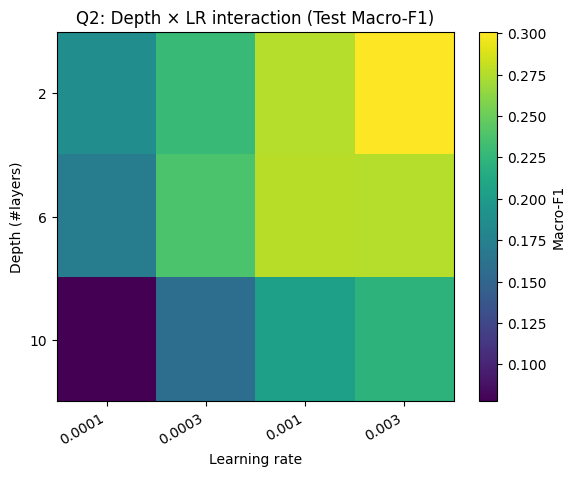

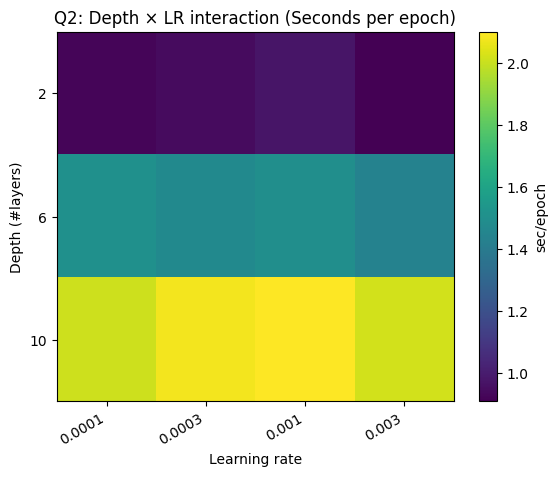

In [24]:
# WHAT THIS CELL DOES
# - Converts Q2 grid results into heatmaps for your report/presentation
# - Macro-F1 heatmap helps discuss the depth×LR interaction visually

# Q2 heatmap: Macro-F1 over (depth, lr)
pivot_f1 = Q2_df.pivot(index="depth", columns="lr", values="test_f1_macro").sort_index()
plt.figure()
plt.imshow(pivot_f1.values, aspect="auto")
plt.xticks(range(len(pivot_f1.columns)), [str(x) for x in pivot_f1.columns], rotation=30, ha="right")
plt.yticks(range(len(pivot_f1.index)), [str(x) for x in pivot_f1.index])
plt.xlabel("Learning rate"); plt.ylabel("Depth (#layers)")
plt.title("Q2: Depth × LR interaction (Test Macro-F1)")
plt.colorbar(label="Macro-F1")
plt.show()

# Q2 heatmap: seconds/epoch over (depth, lr)
pivot_time = Q2_df.pivot(index="depth", columns="lr", values="sec_per_epoch").sort_index()
plt.figure()
plt.imshow(pivot_time.values, aspect="auto")
plt.xticks(range(len(pivot_time.columns)), [str(x) for x in pivot_time.columns], rotation=30, ha="right")
plt.yticks(range(len(pivot_time.index)), [str(x) for x in pivot_time.index])
plt.xlabel("Learning rate"); plt.ylabel("Depth (#layers)")
plt.title("Q2: Depth × LR interaction (Seconds per epoch)")
plt.colorbar(label="sec/epoch")
plt.show()


### Block 14: Save results for the written report

We export the experiment result tables as CSV:
- `Q1_batchsize_results.csv`
- `Q2_depth_lr_results.csv`

These tables are ready to be included in:
- the written report (as tables)
- the presentation (as key numbers next to the plots)

In [25]:
Q1_df.to_csv("Q1_batchsize_results.csv", index=False)
Q2_df.to_csv("Q2_depth_lr_results.csv", index=False)

print("Saved: Q1_batchsize_results.csv")
print("Saved: Q2_depth_lr_results.csv")

Q1_df, Q2_df.head()



Saved: Q1_batchsize_results.csv
Saved: Q2_depth_lr_results.csv


(   batch_size  epochs_ran  train_time_sec  sec_per_epoch  test_acc  \
 0          64          20       60.371878       3.018594  0.318889   
 1         256          20       32.652913       1.632646  0.312281   
 2        1024          20       23.070257       1.153513  0.298655   
 3        4096          20       23.671030       1.183552  0.269123   
 
    test_f1_macro  genre_hit@10  
 0       0.298454      0.218750  
 1       0.290700      0.216167  
 2       0.274033      0.204417  
 3       0.239031      0.189417  ,
    depth      lr  epochs_ran  sec_per_epoch  test_acc  test_f1_macro  \
 0      2  0.0001          25       0.925338  0.222339       0.186679   
 1      2  0.0003          25       0.940564  0.258947       0.228896   
 2      2  0.0010          25       0.974131  0.298480       0.276236   
 3      2  0.0030          25       0.907535  0.317310       0.300908   
 4      6  0.0001          25       1.507399  0.206667       0.171878   
 
    genre_hit@10  
 0        0.1